# Interface Analysis
Here we obtain interfacial residues from parsing the EBI PISA output files. We then assign these residues to monomers in the higher order complexes and highlight them.

## Parsing PISA
PISA outputs files as human-readable .txt files. This makes them tricky to parse. We focus on splitting the file on blank lines into chunk and scraping the relevant information from the chunks of interest

In [16]:
import os
import re
import itertools
from io import StringIO
from collections import OrderedDict
import pandas as pd

In [18]:
class interface_pocket_analysis(object):
    """Contains methods for parsing EBI PISA output interface .txt files"""
    def __init__(self, protein):
        self.protein = protein
        self.interface_path = 'interfaces/' + protein
        self.interfaces = self.get_interface_filenames()
    
    def get_interface_filenames(self):
        files =  os.listdir('interfaces/')
        return [f for f in files if self.protein in f]
    
    def parse_interface_one_residues(self):
        dfs = []
        for i in range(len(self.interfaces)):
            dfs.append(self._parse_interfaces('interfaces/' + self.interfaces[i], chunk=7))      
        return dfs

    def parse_interface_two_residues(self):
        dfs = []
        for i in range(len(self.interfaces)):
            dfs.append(self._parse_interfaces('interfaces/' + self.interfaces[i], chunk=10))      
        return dfs
    
    def _parse_interfaces(self, file_path, chunk):
        print(file_path)
        
        # Split file into list of chunks
        f = self.split_on_empty_lines(open(file_path).read())
        f = f[chunk].replace('| |', '|n|')
        f = f.replace(' ', '|')
    
        f = re.sub(r'(\|)\1+', r'\1', f)
        #Remove problematic HS columns
        f = f.replace('|H|', '|')
        f = f.replace('|S|', '|')
        f = f.replace('|HS|', '|')
        
        # Remove header lines
        f = f.split('\n')[4:-1]
        # Remove leading '|'
        f = [a[1:] for a in f]
        # Join list of strings on newlines
        f = '\n'.join(f)
        f = f.replace('|', ',')[1:]
        # Prep for pandas conversion
        F = StringIO(f)
        df = pd.read_csv(F, sep=",", header=None)
        df = df.loc[df[1] == 'I']
        columns = ['idx', 's|i', 'residue', 'res_num', 'asa', 'bsa', 'delta_G']
        return df
    
    def get_hbonds(self, chunk):
        f = self.f[chunk].replace(' ', '|')
        f = re.sub(r'(\|)\1+', r'\1', f)
        f = f.replace('|H|', '|')
        f = f.replace('|S|', '|')
        f = f.split('\n')[4:-1]
        f = [a[1:] for a in f]
        f = '\n'.join(f)
        f = f.replace('|', ',')[1:]
        return df
        
    def read_pocket_residues(self, pocket_path):
        f = open(filepath, 'r').read()   
        f = f.splitlines()
        f = f[20:-2]
        f = [re.sub('\s+', ',', g) for g in f]
        f = '\n'.join(f)
        columns = ['atom', '']
        F = StringIO(f)
        df = pd.read_csv(F, sep=',', header=None)
        df['res_ind'] = df[4]+':'+df[3]+':'+ df[5].astype(str)
        #df.columns = ['atom', 'atom_num', 'atom_type', 'residue', 'chain', 'res_num', ]
        return df
        
    @staticmethod
    def split_on_empty_lines(s):
        # greedily match 2 or more new-lines
        blank_line_regex = r"(?:\r?\n){2,}"
        return re.split(blank_line_regex, s.strip())
        
print(interface_pocket_analysis('wS_trimer-IGHV3-30-3-Conf1-6NB6').get_interface_filenames())
#print(interface_pocket_analysis('wS_trimer-IGHV3-30-3-Conf1-6NB6').parse_interface_one_residues())
#print(interface_pocket_analysis('wS_trimer-IGHV3-30-3-Conf1-6NB6').parse_interface_two_residues())

['wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_12.txt', 'wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_3.txt', 'wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_10.txt', 'wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_6.txt', 'wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_4.txt', 'wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_9.txt', 'wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_8.txt', 'wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_7.txt', 'wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_5.txt', 'wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_2.txt', 'wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_11.txt', 'wS_trimer-IGHV3-30-3-Conf1-6NB6.interface_1.txt']


### Obtain Interface Residues for each complex

In [19]:
def get_interface_residue_dict(files):
    interface_dict = {}
    for f in files:
        print(f)

        # Parse interface residues 
        interface_one = interface_pocket_analysis(f).parse_interface_one_residues()
        interface_two = interface_pocket_analysis(f).parse_interface_two_residues()
    
        # Extract residues from parsed dataframe
        #interface_residues_one = [i[2] + ':' + i[3].astype(str) for i in interface_one]
        #interface_residues_two = [i[2] + ':' + i[3].astype(str) for i in interface_two]

        # Combine and store residue arrays in a dictionary
        interfaces = pd.concat(interface_one + interface_two)
        interface_dict[f] = interfaces
    return interface_dict

# Get Intraviral Complexes
iv_files = os.listdir('structures/korkin_lab/IntraViralComplexes')
iv_files = [f[:-4] for f in iv_files if f.endswith('.pdb')]
print(iv_files)
intraviral_interfaces = get_interface_residue_dict(iv_files)

# Get Viral Human Complexes
vh_files = os.listdir('structures/korkin_lab/ViralHumanComplexes/')
vh_files = [f[:-4] for f in vh_files if f.endswith('.pdb')]
print(vh_files)
viral_human_interfaces = get_interface_residue_dict(vh_files)

['wN-Nterminal_domain_homopentamer-4UD1', 'wS_homotrimer-Conf2-5X5B', 'wNsp3-domain2_homotetramer-2acf', 'wNsp3-domain3_homotetramer-2wct', 'wNsp4_homodimer-3vc8', 'wE_homopentamer-5X29', 'wS_homotrimer-Conf1-5X58', 'wN-Cterminal_domain_homodimer-2JW8', 'wS_homotrimer-Conf1-6CS0', 'wNsp7-wNsp8-wNsp12_heterotetramer-6nur', 'wNsp9_tetramer-3ee7', 'wNsp5_homodimer-2gt7', 'wNsp10_dodecamer-2g9t', 'wNsp13_homodimer-6jyt', 'wNsp10-wNsp14_heterodimer-5c8u', 'wS_homotrimer-Conf2-6CS1', 'wS_homotrimer_treated-Conf1-6ACC', 'wS_homotrimer_treated-Conf2-6ACD', 'wNsp10-wNsp16_heterodimer-2xyq']
wN-Nterminal_domain_homopentamer-4UD1
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_8.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_1.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_5.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_4.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_3.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1

## Visualise Interfaces

In [21]:
from ipymol import viewer as pymol

select interface, chain C and resi 918+921+922+924+925+928+929+931+932+935+936+944+947+948+951+965+966+967+968+969+970+972+973+974+975+976+977+979+981+982+983+984+985+987+918+920+921+923+924+927+928+930+931+934+939+942+945+946+949+952+953+956+957+940+941+942+943
select interface, chain A and resi 293+294+295+296+297+299+304+308+313+315+321+322+324+325+326+327+328+329+330+434+435+436+727+154+155+156+157+158+207+208+209+210+211+212+213+214+215+216+219+222+223+224+225+228+239+250+252+255+256+258+259+262+263+264+265+266+267+268+269+270+271+272+273+274+275+276+280+282+283+284+286+287+288+289+291+331+389+390+392+393+398+399+401+402+403+407+550+559+298+299+301+304+308
select interface, chain D and resi 988+991+992+994+995+996+998+999+150+159+113+72+26+53+43+57+39+197+63+44+85+69+158+39+154+12+80+991+994+997+998+159
select interface, chain B and resi 889+890+905+906+907+908+909+804+806+807+810+811+813+814+815+817+818+819+821+822+824+825+826+830+831+833+834+836+837+838+839+840+841+842+843+844+8

IntProgress(value=0, max=48)

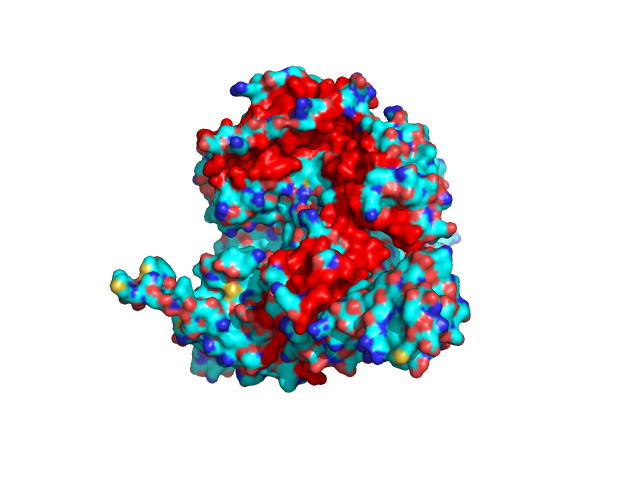

In [31]:
def visualise_interfaces(path_stem, protein):
    
    # Load structure, split chains and display as surface
    pymol.do(f'load {os.getcwd()}/structures/{path_stem}{protein}')
    pymol.do('split_chains')
    pymol.show_as('surface')
    
    # Retrieve interface dataframes from dictionary
    interface_residues = intraviral_interfaces[protein[:-4]]      
    
    # Identify chains to iterate selections over
    chains = set([r[0] for r in interface_residues[2]])

    for chain in chains:
        # Select interface residues for chains and color them red
        s = interface_residues.loc[interface_residues[2].str.startswith(chain)]
        selection_query = f'select interface, chain {chain} and resi {s[3].astype(int).astype(str).str.cat(sep="+")}'
        print(selection_query)
        pymol.do(selection_query)
        pymol.do('color red, interface')
        
visualise_interfaces(path_stem='korkin_lab/IntraViralComplexes/', protein='wNsp7-wNsp8-wNsp12_heterotetramer-6nur.pdb')
pymol.display()

### Map Interface Residues to subunits

In [24]:
monomers = [f.split('_') for f in iv_files]
monomers

[['wN-Nterminal', 'domain', 'homopentamer-4UD1'],
 ['wS', 'homotrimer-Conf2-5X5B'],
 ['wNsp3-domain2', 'homotetramer-2acf'],
 ['wNsp3-domain3', 'homotetramer-2wct'],
 ['wNsp4', 'homodimer-3vc8'],
 ['wE', 'homopentamer-5X29'],
 ['wS', 'homotrimer-Conf1-5X58'],
 ['wN-Cterminal', 'domain', 'homodimer-2JW8'],
 ['wS', 'homotrimer-Conf1-6CS0'],
 ['wNsp7-wNsp8-wNsp12', 'heterotetramer-6nur'],
 ['wNsp9', 'tetramer-3ee7'],
 ['wNsp5', 'homodimer-2gt7'],
 ['wNsp10', 'dodecamer-2g9t'],
 ['wNsp13', 'homodimer-6jyt'],
 ['wNsp10-wNsp14', 'heterodimer-5c8u'],
 ['wS', 'homotrimer-Conf2-6CS1'],
 ['wS', 'homotrimer', 'treated-Conf1-6ACC'],
 ['wS', 'homotrimer', 'treated-Conf2-6ACD'],
 ['wNsp10-wNsp16', 'heterodimer-2xyq']]

## Parse Pockets

In [8]:
## Load druggable pockets
individual_model_pocket_index = pd.read_csv('pockets/korkin_individual_model_druggable.csv')
individual_model_pocket_index.head()

,Unnamed: 0,Score,Druggability Score,Number of Alpha Spheres,Total SASA,Polar SASA,Apolar SASA,Volume,Mean local hydrophobic density,Mean alpha sphere radius :,...,Hydrophobicity score:,Volume score:,Polarity score:,Charge score :,Proportion of polar atoms:,Alpha sphere density,Cent. of mass - Alpha Sphere max dist:,Flexibility,pocket_number,protein
0,1,0.226,0.602,92,170.448,49.685,120.763,575.123,54.825,3.895,...,27.316,3.684,8,-1,33.962,5.074,12.082,0.375,2,wS-5xlr_C-6acj_C
1,0,0.349,0.548,53,66.047,14.040,52.007,274.970,28.065,3.632,...,29.200,4.000,6,-1,32.432,3.980,8.223,0.714,1,wNsp12-6nurA
2,3,0.222,0.949,91,238.119,70.021,168.098,678.351,31.228,3.764,...,29.040,4.040,8,2,34.483,7.039,16.229,0.657,4,wNsp12-6nurA
3,1,0.136,0.759,61,164.152,57.881,106.271,520.343,27.267,3.985,...,30.250,4.417,5,0,32.353,4.235,12.720,0.656,2,wNsp3_domain5-3e9sA
4,0,0.306,0.729,17,78.364,11.786,66.578,301.616,11.000,4.041,...,69.000,4.182,2,0,20.000,3.835,9.434,0.654,1,wNsp9-3ee7


In [25]:
def read_pocket_residues(filepath):
    # Open pocket files (xxx/pocketX_atm.pdb)
    f = open(filepath, 'r').read()   
    
    # Split file on blank lines, skip header & footer, parse
    f = f.splitlines()
    f = f[20:-2]
    f = [re.sub('\s+', ',', g) for g in f]
    f = '\n'.join(f)

    # Make Pandas DF
    F = StringIO(f)
    df = pd.read_csv(F, sep=',', header=None)
    
    # Create residue identifier column
    df['res_ind'] = df[3] + ':' + df[4].astype(str)
    return df


def get_pocket_residues(protein, pocket_index_df):
    pocket_subset = pocket_index_df.loc[pocket_index_df['protein'] == protein]
    file_paths = os.getcwd() + '/pockets/korkin_lab/IndividualModels/' + protein + '_out/pockets/pocket' + pocket_subset['pocket_number'].astype(str) + '_atm.pdb' 
    pocket_residues = [read_pocket_residues(p) for p in file_paths]
    print(pocket_residues)    
    
    #for fp in file_paths:
    #    print(fp)
    #    pocket_residues = read_pocket_residues(fp)   
    
    
get_pocket_residues('wNsp9-3ee7', pocket_index_df=individual_model_pocket_index)

[       0    1    2    3    4       5       6       7     8     9 10  11  \
0   ATOM  788   CB  LEU  103  33.284  30.813  44.823  0.00  0.00  C   0   
1   ATOM  795   CA  ALA  104  34.070  26.560  43.983  0.00  0.00  C   0   
2   ATOM  792    C  LEU  103  34.470  28.682  45.092  0.00  0.00  C   0   
3   ATOM  793    O  LEU  103  34.438  28.149  46.199  0.49  1.07  O   0   
4   ATOM  794    N  ALA  104  34.344  27.971  43.956  0.00  0.00  N   0   
5   ATOM  814  CG1  VAL  107  33.298  24.262  48.887  0.00  0.00  C   0   
6   ATOM  559    O  VAL   73  28.658  27.610  50.269  0.70  5.36  O   0   
7   ATOM  810    O  THR  106  34.567  26.751  49.172  0.00  0.00  O   0   
8   ATOM  564  CG2  THR   74  31.053  29.736  50.347  0.00  0.00  C   0   
9   ATOM  547  CD2  PHE   72  28.947  31.022  48.273  0.00  0.00  C   0   
10  ATOM  673  CE2  PHE   87  28.367  36.038  39.570  0.00  0.00  C   0   
11  ATOM  773  CD2  LEU  100  30.287  31.929  39.711  0.00  0.00  C   0   
12  ATOM  527   CB  CYS 

### Visualise Interfaces residues on monomers